In [1]:
import numpy as np
import pandas as pd

import scipy
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sb

import sklearn
# from sklearn import datasets
from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm
from sklearn.preprocessing import scale

In [2]:
# Configure the output
np.set_printoptions(precision=4,suppress=True)
%matplotlib inline
rcParams["figure.figsize"] =20,10
sb.set_style("whitegrid")

In [ ]:
# read_csv to get distance scores of each sentence pair.

In [4]:
df_clean = df.loc[df['score'] != 'na']
df_clean.describe()

NameError: name 'df' is not defined

In [ ]:
df_clean = df_clean.copy()
df_clean['dist'] = df_clean['score'].astype(int)
df_clean.head()

In [ ]:
df_clean = df_clean.drop(columns=['score'])
df_clean.head()

In [ ]:
df_clean.describe()

### import from csv instead.

In [37]:
df_clean = pd.read_csv("../data/roberta/Astro1_decomposed_clean_pairs_roberta_distances.csv")
df_pairs = pd.read_csv("../data/Astro1_decomposed_clean_pairs.csv")
display(df_clean.head(), df_pairs.head())

,Unnamed: 0,predicted_class,C,N,E,dist
0,0,neutral,0.022798,0.880442,0.096760,0.450491
1,1,entailment,0.001746,0.039801,0.958454,0.019935
2,2,neutral,0.004882,0.990273,0.004845,0.497565
3,3,neutral,0.052050,0.944104,0.003846,0.497971
4,4,entailment,0.001493,0.161846,0.836661,0.081044


,Unnamed: 0,first,second
0,0,You never give up.,You never find it difficult to change your min...
1,1,You never give up.,"Whatever you have set your sights on, you refu..."
2,2,You never give up.,You are patient unless someone takes you too far.
3,3,You never give up.,You are usually slow to anger unless someone t...
4,4,You never give up.,You are reliable.


In [38]:
df_clean = df_clean.drop(columns=["Unnamed: 0"])
df_pairs = df_pairs.drop(columns=["Unnamed: 0"])
display(df_clean.head(), df_pairs.head())

,predicted_class,C,N,E,dist
0,neutral,0.022798,0.880442,0.096760,0.450491
1,entailment,0.001746,0.039801,0.958454,0.019935
2,neutral,0.004882,0.990273,0.004845,0.497565
3,neutral,0.052050,0.944104,0.003846,0.497971
4,entailment,0.001493,0.161846,0.836661,0.081044


,first,second
0,You never give up.,You never find it difficult to change your min...
1,You never give up.,"Whatever you have set your sights on, you refu..."
2,You never give up.,You are patient unless someone takes you too far.
3,You never give up.,You are usually slow to anger unless someone t...
4,You never give up.,You are reliable.


In [39]:
df_pairs = df_pairs.assign(dist=df_clean['dist'])

In [40]:
df_pairs.head()

,first,second,dist
0,You never give up.,You never find it difficult to change your min...,0.450491
1,You never give up.,"Whatever you have set your sights on, you refu...",0.019935
2,You never give up.,You are patient unless someone takes you too far.,0.497565
3,You never give up.,You are usually slow to anger unless someone t...,0.497971
4,You never give up.,You are reliable.,0.081044


In [3]:
df_pairs = pd.read_csv("../data/astro0/astro0_decomposed_processed_pairs.csv")
df_pairs.head()

,Unnamed: 0,first,second,first_index,second_index,C1,N1,E1,C2,N2,E2,dist
0,0,"People with Virgo rising tend to be practical,...",You have an ingenious mind.,0,1,0.014990,0.901193,0.083817,0.168603,0.702198,0.129199,0.457454
1,1,"People with Virgo rising tend to be practical,...",You have an active mind.,0,2,0.021296,0.439075,0.539628,0.890627,0.093778,0.015595,0.890627
2,2,"People with Virgo rising tend to be practical,...",You have an alert mind.,0,3,0.002648,0.244821,0.752531,0.061536,0.715761,0.222702,0.122736
3,3,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,0,4,0.001137,0.633402,0.365460,0.029134,0.667270,0.303596,0.343647
4,4,"People with Virgo rising tend to be practical,...",You strive for perfection.,0,5,0.001929,0.536462,0.461609,0.041221,0.582456,0.376323,0.303749


### actual processing begins here.

In [6]:
# convert this original dataframe to a 'square' distance matrix.
# we utilise a pivot table to do this

# first, add the redundant pairs (two of the same sentences) to the data.
# we need this for the pivot function to generate the correct indices and columns.
first = np.unique(df_pairs['first_index'].values)
second = np.unique(df_pairs['second_index'].values)
combined_arr = np.concatenate((first, second))
sentences = np.unique(combined_arr)
print(len(sentences))

88


In [9]:
#add_data = np.column_stack([np.zeros(len(sentences)), np.zeros(len(sentences)), np.zeros(len(sentences)), np.zeros(len(sentences)), sentences, sentences, np.zeros(len(sentences))])
add_data = np.column_stack([sentences, sentences, np.zeros(len(sentences))])
add_data = add_data.astype(np.int)

print(add_data)

[[ 0  0  0]
 [ 1  1  0]
 [ 2  2  0]
 [ 3  3  0]
 [ 4  4  0]
 [ 5  5  0]
 [ 6  6  0]
 [ 7  7  0]
 [ 8  8  0]
 [ 9  9  0]
 [10 10  0]
 [11 11  0]
 [12 12  0]
 [13 13  0]
 [14 14  0]
 [15 15  0]
 [16 16  0]
 [17 17  0]
 [18 18  0]
 [19 19  0]
 [20 20  0]
 [21 21  0]
 [22 22  0]
 [23 23  0]
 [24 24  0]
 [25 25  0]
 [26 26  0]
 [27 27  0]
 [28 28  0]
 [29 29  0]
 [30 30  0]
 [31 31  0]
 [32 32  0]
 [33 33  0]
 [34 34  0]
 [35 35  0]
 [36 36  0]
 [37 37  0]
 [38 38  0]
 [39 39  0]
 [40 40  0]
 [41 41  0]
 [42 42  0]
 [43 43  0]
 [44 44  0]
 [45 45  0]
 [46 46  0]
 [47 47  0]
 [48 48  0]
 [49 49  0]
 [50 50  0]
 [51 51  0]
 [52 52  0]
 [53 53  0]
 [54 54  0]
 [55 55  0]
 [56 56  0]
 [57 57  0]
 [58 58  0]
 [59 59  0]
 [60 60  0]
 [61 61  0]
 [62 62  0]
 [63 63  0]
 [64 64  0]
 [65 65  0]
 [66 66  0]
 [67 67  0]
 [68 68  0]
 [69 69  0]
 [70 70  0]
 [71 71  0]
 [72 72  0]
 [73 73  0]
 [74 74  0]
 [75 75  0]
 [76 76  0]
 [77 77  0]
 [78 78  0]
 [79 79  0]
 [80 80  0]
 [81 81  0]
 [82 82  0]
 [83

In [10]:
add_df = pd.DataFrame(data=add_data, columns=['first_index','second_index','dist'])
add_df.head()

,first_index,second_index,dist
0,0,0,0
1,1,1,0
2,2,2,0
3,3,3,0
4,4,4,0


In [11]:
df_pairs = df_pairs.append(add_df, ignore_index=True)

,Unnamed: 0,first,second,first_index,second_index,C1,N1,E1,C2,N2,E2,dist
3911,NaN,NaN,NaN,83,83,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3912,NaN,NaN,NaN,84,84,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3913,NaN,NaN,NaN,85,85,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3914,NaN,NaN,NaN,86,86,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3915,NaN,NaN,NaN,87,87,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [12]:
display(df_pairs.head(), df_pairs.tail())

,Unnamed: 0,first,second,first_index,second_index,C1,N1,E1,C2,N2,E2,dist
0,0.0,"People with Virgo rising tend to be practical,...",You have an ingenious mind.,0,1,0.014990,0.901193,0.083817,0.168603,0.702198,0.129199,0.457454
1,1.0,"People with Virgo rising tend to be practical,...",You have an active mind.,0,2,0.021296,0.439075,0.539628,0.890627,0.093778,0.015595,0.890627
2,2.0,"People with Virgo rising tend to be practical,...",You have an alert mind.,0,3,0.002648,0.244821,0.752531,0.061536,0.715761,0.222702,0.122736
3,3.0,"People with Virgo rising tend to be practical,...",Gaining knowledge and putting it to good use a...,0,4,0.001137,0.633402,0.365460,0.029134,0.667270,0.303596,0.343647
4,4.0,"People with Virgo rising tend to be practical,...",You strive for perfection.,0,5,0.001929,0.536462,0.461609,0.041221,0.582456,0.376323,0.303749


,Unnamed: 0,first,second,first_index,second_index,C1,N1,E1,C2,N2,E2,dist
3911,NaN,NaN,NaN,83,83,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3912,NaN,NaN,NaN,84,84,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3913,NaN,NaN,NaN,85,85,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3914,NaN,NaN,NaN,86,86,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3915,NaN,NaN,NaN,87,87,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [14]:
df_piv = df_pairs.pivot("first_index", "second_index", "dist").fillna(0)
piv_arr = df_piv.values
dist_mat = piv_arr + np.transpose(piv_arr)

In [15]:
df_piv.head()

second_index,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
first_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.457454,0.890627,0.122736,0.343647,0.303749,0.494094,0.498978,0.428174,0.499487,...,0.490302,0.497844,0.497375,0.401196,0.489331,0.993485,0.491715,0.494522,0.378094,0.391084
1,0.0,0.000000,0.032994,0.130562,0.498068,0.495861,0.498606,0.486919,0.480689,0.499531,...,0.485482,0.497580,0.498825,0.486510,0.874905,0.987602,0.485783,0.417588,0.497986,0.493121
2,0.0,0.000000,0.000000,0.002692,0.456897,0.492376,0.498840,0.481217,0.465977,0.499415,...,0.496183,0.495881,0.499339,0.612499,0.667300,0.994634,0.498959,0.493914,0.491291,0.494619
3,0.0,0.000000,0.000000,0.000000,0.458032,0.484349,0.498572,0.487478,0.456454,0.499436,...,0.496204,0.497620,0.499115,0.769684,0.424280,0.998456,0.497800,0.486022,0.490840,0.493866
4,0.0,0.000000,0.000000,0.000000,0.000000,0.440961,0.499034,0.499095,0.831255,0.499499,...,0.452073,0.498734,0.499442,0.989376,0.861346,0.499028,0.490917,0.481579,0.367555,0.460451


In [17]:
from scipy.spatial.distance import squareform
condensed_mat = squareform(dist_mat)

In [18]:
df_piv.index == df_piv.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [19]:
linkage_arr = linkage(condensed_mat)

In [20]:
linkage_arr

array([[ 20.    ,  21.    ,   0.0026,   2.    ],
       [  2.    ,   3.    ,   0.0027,   2.    ],
       [ 70.    ,  71.    ,   0.003 ,   2.    ],
       [ 74.    ,  75.    ,   0.0049,   2.    ],
       [ 48.    ,  89.    ,   0.0053,   3.    ],
       [ 86.    ,  87.    ,   0.0072,   2.    ],
       [ 17.    ,  38.    ,   0.0102,   2.    ],
       [ 54.    ,  68.    ,   0.0111,   2.    ],
       [ 67.    ,  94.    ,   0.0152,   3.    ],
       [ 79.    ,  80.    ,   0.0269,   2.    ],
       [ 33.    ,  34.    ,   0.0285,   2.    ],
       [  1.    ,  92.    ,   0.0305,   4.    ],
       [ 18.    ,  96.    ,   0.0406,   4.    ],
       [ 88.    , 100.    ,   0.0465,   6.    ],
       [ 39.    ,  85.    ,   0.0521,   2.    ],
       [ 32.    ,  81.    ,   0.0531,   2.    ],
       [ 99.    , 101.    ,   0.0683,  10.    ],
       [ 95.    , 104.    ,   0.0857,  12.    ],
       [102.    , 105.    ,   0.0898,  14.    ],
       [ 35.    ,  93.    ,   0.0899,   3.    ],
       [  5.    , 10

{'icoord': [[175.0, 175.0, 185.0, 185.0],
  [295.0, 295.0, 305.0, 305.0],
  [315.0, 315.0, 325.0, 325.0],
  [300.0, 300.0, 320.0, 320.0],
  [285.0, 285.0, 310.0, 310.0],
  [365.0, 365.0, 375.0, 375.0],
  [415.0, 415.0, 425.0, 425.0],
  [455.0, 455.0, 465.0, 465.0],
  [505.0, 505.0, 515.0, 515.0],
  [535.0, 535.0, 545.0, 545.0],
  [625.0, 625.0, 635.0, 635.0],
  [645.0, 645.0, 655.0, 655.0],
  [685.0, 685.0, 695.0, 695.0],
  [675.0, 675.0, 690.0, 690.0],
  [665.0, 665.0, 682.5, 682.5],
  [705.0, 705.0, 715.0, 715.0],
  [745.0, 745.0, 755.0, 755.0],
  [735.0, 735.0, 750.0, 750.0],
  [725.0, 725.0, 742.5, 742.5],
  [710.0, 710.0, 733.75, 733.75],
  [673.75, 673.75, 721.875, 721.875],
  [650.0, 650.0, 697.8125, 697.8125],
  [630.0, 630.0, 673.90625, 673.90625],
  [615.0, 615.0, 651.953125, 651.953125],
  [605.0, 605.0, 633.4765625, 633.4765625],
  [595.0, 595.0, 619.23828125, 619.23828125],
  [805.0, 805.0, 815.0, 815.0],
  [795.0, 795.0, 810.0, 810.0],
  [785.0, 785.0, 802.5, 802.5],
  [7

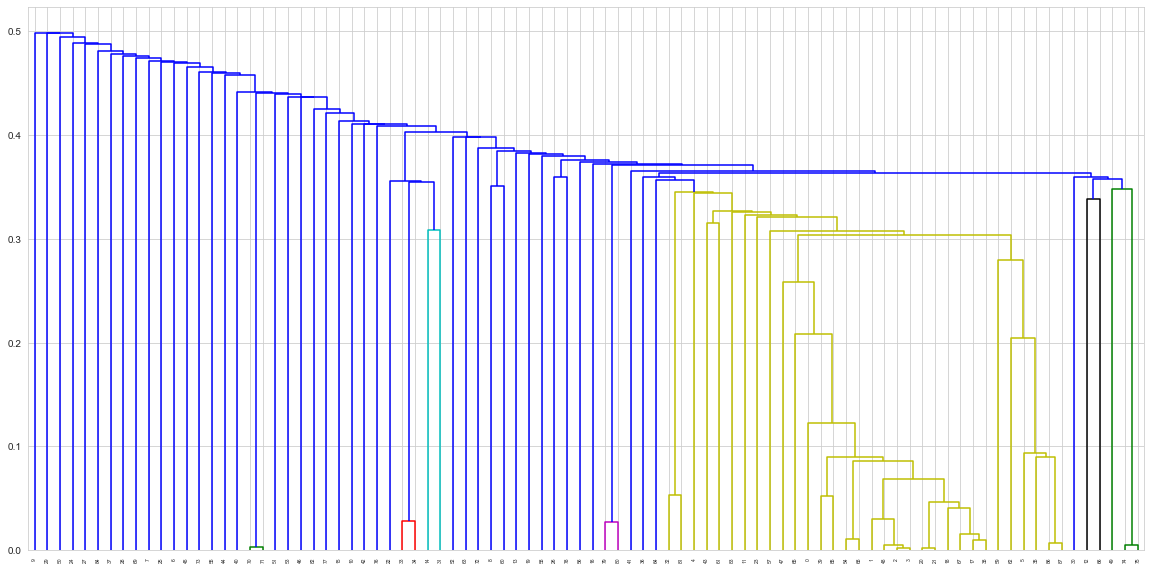

In [21]:
dendrogram(linkage_arr,
            orientation='top',
            labels=df_piv.index.values,
            distance_sort='descending',
            show_leaf_counts=True)

In [22]:
sil_scores = []
for i in range(2, len(dist_mat)):
    clusters = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)

    # use metric to measure/compare goodness of clusters based on internal coherence and 
    # external coupling.
    # consider Dunn index. maximise the Dunn index.
    # or consider average sillhouette width (maximise). available in sklearn.
    from sklearn.metrics import silhouette_score

    silhouette_avg = silhouette_score(dist_mat, clusters.labels_, metric='precomputed')
    sil_scores.append(silhouette_avg)
    print(i, ": ", silhouette_avg)

2 :  -0.05241891289886036
3 :  -0.05901542031361908
4 :  -0.06018584843694808
5 :  -0.05716940703764129
6 :  -0.056872432524820056
7 :  -0.06191846140901349
8 :  -0.06436408745188858
9 :  -0.06534494781965818
10 :  -0.0674695368647271
11 :  -0.07184590900623723
12 :  -0.07247709360085076
13 :  -0.07161386512563668
14 :  -0.06062987399730813
15 :  -0.06525364354908697
16 :  -0.06516456248717639
17 :  -0.06332177312863219
18 :  -0.07082540056375777
19 :  -0.051367126284890444
20 :  -0.0518350134406919
21 :  -0.05336115774301102
22 :  -0.05629047403840923
23 :  -0.05716217972474005
24 :  -0.059693464527862214
25 :  -0.06223606639751736
26 :  -0.0627864732739817
27 :  -0.06356443251072044
28 :  -0.06766907972266491
29 :  -0.055883485504727395
30 :  -0.053649212765193695
31 :  -0.05496491228067358
32 :  -0.05278766708446516
33 :  -0.04368373919532682
34 :  -0.04470257353310316
35 :  -0.04630969004533301
36 :  -0.05056630158664348
37 :  -0.04270502469668302
38 :  -0.03988159714983563
39 :  -

In [23]:
sil_scores_arr = np.asarray(sil_scores)
print('max avg silhouette score: ', sil_scores_arr.max())
optimal_k = np.where(sil_scores_arr == sil_scores_arr.max())[0][0] + 2
print('nclusters w max avg silhouette score: ', optimal_k)

max avg silhouette score:  0.2100317730046518
nclusters w max avg silhouette score:  72


In [24]:
clusters = AgglomerativeClustering(n_clusters=optimal_k, affinity='precomputed', linkage='single')
clusters.fit_predict(dist_mat)
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    
    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(df_piv.index[idx])
    print('\n')

cluster 0 (size 2):
[32 81]


32

81



cluster 1 (size 2):
[39 85]


39

85



cluster 2 (size 6):
[17 18 20 21 38 67]


17

18

20

21

38

67



cluster 3 (size 4):
[ 1  2  3 48]


1

2

3

48



cluster 4 (size 1):
[82]


82



cluster 5 (size 2):
[33 34]


33

34



cluster 6 (size 2):
[86 87]


86

87



cluster 7 (size 2):
[54 68]


54

68



cluster 8 (size 2):
[79 80]


79

80



cluster 9 (size 1):
[78]


78



cluster 10 (size 1):
[64]


64



cluster 11 (size 1):
[77]


77



cluster 12 (size 2):
[74 75]


74

75



cluster 13 (size 1):
[83]


83



cluster 14 (size 1):
[84]


84



cluster 15 (size 1):
[69]


69



cluster 16 (size 2):
[70 71]


70

71



cluster 17 (size 1):
[66]


66



cluster 18 (size 1):
[56]


56



cluster 19 (size 1):
[51]


51



cluster 20 (size 1):
[61]


61



cluster 21 (size 1):
[36]


36



cluster 22 (size 1):
[60]


60



cluster 23 (size 1):
[27]


27



cluster 24 (size 1):
[49]


49



cluster 25 (size 1):
[42]


42



cluster 26 (size 1):
[31]


31



cluster 27 (size 1):
[76]


76



cluster 28 (size 1):
[73]


73



cluster 29 (size 1):
[57]


57



cluster 30 (size 1):
[63]


63



cluster 31 (size 1):
[65]


65



cluster 32 (size 1):
[62]


62



cluster 33 (size 1):
[35]


35



cluster 34 (size 1):
[72]


72



cluster 35 (size 1):
[58]


58



cluster 36 (size 1):
[55]


55



cluster 37 (size 1):
[40]


40



cluster 38 (size 1):
[16]


16



cluster 39 (size 1):
[24]


24



cluster 40 (size 1):
[41]


41



cluster 41 (size 1):
[50]


50



cluster 42 (size 1):
[26]


26



cluster 43 (size 1):
[7]


7



cluster 44 (size 1):
[30]


30



cluster 45 (size 1):
[46]


46



cluster 46 (size 1):
[53]


53



cluster 47 (size 1):
[22]


22



cluster 48 (size 1):
[25]


25



cluster 49 (size 1):
[8]


8



cluster 50 (size 1):
[15]


15



cluster 51 (size 1):
[6]


6



cluster 52 (size 1):
[4]


4



cluster 53 (size 1):
[10]


10



cluster 54 (size 1):
[12]


12



cluster 55 (size 1):
[29]


29



cluster 56 (size 1):
[11]


11



cluster 57 (size 1):
[23]


23



cluster 58 (size 1):
[43]


43



cluster 59 (size 1):
[14]


14



cluster 60 (size 1):
[45]


45



cluster 61 (size 1):
[52]


52



cluster 62 (size 1):
[59]


59



cluster 63 (size 1):
[9]


9



cluster 64 (size 1):
[47]


47



cluster 65 (size 1):
[44]


44



cluster 66 (size 1):
[0]


0



cluster 67 (size 1):
[5]


5



cluster 68 (size 1):
[13]


13



cluster 69 (size 1):
[19]


19



cluster 70 (size 1):
[37]


37



cluster 71 (size 1):
[28]


28

In [27]:
import json
# save clusters into JSON dict
clusters_dict = dict()
for i in range(clusters.n_clusters_):
    indices = np.where(clusters.labels_ == i)[0]
    sents = list()
    for idx in indices:
        sents.append(int(df_piv.index[idx]))
    clusters_dict[i] = sents
path = input("enter path to save clusters json file:\n")
with open(path, 'w') as fp:
    json.dump(clusters_dict, fp)

enter path to save clusters json file:
 ../data/astro0/astro0_decomposed_roberta_clusters.json


In [28]:
# create symmetric pivot df for saving.
df_piv_symmetric = pd.DataFrame(data=dist_mat, index=df_piv.index, columns=df_piv.columns)
df_piv_symmetric.head()

second_index,0,1,2,3,4,5,6,7,8,9,...,78,79,80,81,82,83,84,85,86,87
first_index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.457454,0.890627,0.122736,0.343647,0.303749,0.494094,0.498978,0.428174,0.499487,...,0.490302,0.497844,0.497375,0.401196,0.489331,0.993485,0.491715,0.494522,0.378094,0.391084
1,0.457454,0.000000,0.032994,0.130562,0.498068,0.495861,0.498606,0.486919,0.480689,0.499531,...,0.485482,0.497580,0.498825,0.486510,0.874905,0.987602,0.485783,0.417588,0.497986,0.493121
2,0.890627,0.032994,0.000000,0.002692,0.456897,0.492376,0.498840,0.481217,0.465977,0.499415,...,0.496183,0.495881,0.499339,0.612499,0.667300,0.994634,0.498959,0.493914,0.491291,0.494619
3,0.122736,0.130562,0.002692,0.000000,0.458032,0.484349,0.498572,0.487478,0.456454,0.499436,...,0.496204,0.497620,0.499115,0.769684,0.424280,0.998456,0.497800,0.486022,0.490840,0.493866
4,0.343647,0.498068,0.456897,0.458032,0.000000,0.440961,0.499034,0.499095,0.831255,0.499499,...,0.452073,0.498734,0.499442,0.989376,0.861346,0.499028,0.490917,0.481579,0.367555,0.460451


In [29]:
path = input("enter path to save csv file for pairwise distances:\n")
df_piv_symmetric.to_csv(path)

enter path to save csv file for pairwise distances:
 ../data/astro0/astro0_decomposed_roberta_pairwisematrix.csv


### extra: more exploration for choosing "optimal" clusters.

If we use the cutting method on the dengrogram generated much earlier, then we'll end up with 6, 19, 44 or 60 clusters depending on where we cut. However, for the lower number of clusters (e.g. 6 or 19, the cluster sizes are highly imbalanced). We should take a closer look at the contents of the clusters formed.

In [ ]:
for chosen_k in [6, 19, 44, 60]:
    print('------')
    print(f'\n{chosen_k}')
    clusters = AgglomerativeClustering(n_clusters=chosen_k, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)
    for i in range(clusters.n_clusters_):
        indices = np.where(clusters.labels_ == i)[0]

        print(f'cluster {i} (size {len(indices)}):')
        print(indices)
        for idx in indices:
            display(df_piv.index[idx])
        print('\n')

We could try different linkage algorithms to see their effects too. But we'll leave this for another time.

Let's try visualising (approximately) a graph from the distance matrix:

In [41]:
import networkx as nx
import string

In [42]:
G = nx.from_numpy_matrix(dist_mat)
print(G.nodes())
print(G.edges())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (0, 23), (0, 24), (0, 25), (0, 26), (0, 27), (0, 28), (0, 29), (0, 30), (0, 31), (0, 32), (0, 33), (0, 34), (0, 35), (0, 36), (0, 37), (0, 38), (0, 39), (0, 40), (0, 41), (0, 42), (0, 43), (0, 44), (0, 45), (0, 46), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (1, 23), (1, 24), (1, 25), (1, 26), (1, 27), (1, 28), (1, 29), (1, 30), (1, 31), (1, 32), (1, 33), (1, 34), (1, 35), (1, 36), (1, 37), (1, 38), (1, 39), (1, 40), (1, 41), (1, 42), (1, 43), (1, 44), (1, 45), (1, 46), (2, 3), (2, 4), (2

In [43]:
G = nx.from_numpy_matrix(dist_mat)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),string.ascii_uppercase)))

In [45]:
import pydot
from networkx.drawing.nx_pydot import write_dot
print("using package pydot")
path = input("enter path to save dot file:\n")
write_dot(G, path)

using package pydot


enter path to save dot file:
 ../data/viz/Astro1_decomposed_clean_pairs_roberta.dot


Provide generated dotfile to Graphviz neato program for advanced visualisation. Voila!

In [46]:
for i in range(len(df_piv.index)):
    print(i, ' ', df_piv.index[i])

0   Debate and argument appeal to you.
1   Keeping things going is your strength, especially once someone else starts them.
2   Money and possessions are important to you for the feelings of security they bring.
3   Whatever you have set your sights on, you refuse to give up or let go of it.
4   You are adventurous.
5   You are consistent.
6   You are courageous.
7   You are gentle.
8   You are handy with your hands.
9   You are independent.
10   You are patient unless someone takes you too far.
11   You are quiet.
12   You are reliable.
13   You are romantic.
14   You are sensitive.
15   You are sentimental.
16   You are shy.
17   You are usually outspoken, sometimes to the point of bluntness.
18   You are usually slow to anger unless someone takes you too far.
19   You are very direct in thought, action, and speech and everyone knows how you feel.
20   You can handle more of the workload than most around you.
21   You enjoy building and seeing the results of your hard work.
22   You 

I need to find the distances between clusters. to gauge how similar 2 clusters are in relation to one another. I could just use the visualisation tool to visually identify clusters far from each other and try to compare their cluster meanings.

In [47]:
clusters = AgglomerativeClustering(n_clusters=39, affinity='precomputed', linkage='single')
labels = clusters.fit_predict(dist_mat)

from sklearn.metrics import silhouette_samples

silhouette_samples = silhouette_samples(dist_mat, clusters.labels_, metric='precomputed')

print('no. of clusters found:', ' ', clusters.n_clusters_)
print('no. of samples: ', len(silhouette_samples))

for i in range(len(silhouette_samples)):
    print(i, ': ', silhouette_samples[i])

no. of clusters found:   39
no. of samples:  47
0 :  0.0
1 :  0.0
2 :  0.0
3 :  0.0
4 :  0.0
5 :  0.642095879282839
6 :  0.0
7 :  0.0
8 :  0.0
9 :  0.0
10 :  0.9829472362326903
11 :  0.0
12 :  0.8970621816199157
13 :  0.0
14 :  0.0
15 :  0.0
16 :  0.0
17 :  0.0
18 :  0.9836908160481713
19 :  0.0
20 :  0.0
21 :  0.0
22 :  0.0
23 :  0.9825751589154322
24 :  0.5816944135901622
25 :  0.0
26 :  0.0
27 :  0.0
28 :  0.0
29 :  0.0
30 :  0.9937494487658421
31 :  0.9930882383455576
32 :  0.862683660920535
33 :  0.0
34 :  0.0
35 :  0.9331633182778146
36 :  0.36885968477413467
37 :  0.0
38 :  0.8298688456541156
39 :  0.426567938530809
40 :  0.0
41 :  0.0
42 :  0.9931529771934257
43 :  0.9934520368842715
44 :  0.0
45 :  0.0
46 :  0.0


### Compute the "average" pairwise distance of one cluster with another cluster, storing the result in a pairwise matrix.

In [30]:
for n_clusters in [optimal_k]:
    print('------')
    print(f'\nno. of clusters = {n_clusters}')
    clusters = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='single')
    clusters.fit_predict(dist_mat)
    
    # find average distances between clusters and output a new distance matrix
    labels = [i for i in range(clusters.n_clusters_)]
    avg_dist_arr = np.zeros(shape=(clusters.n_clusters_, clusters.n_clusters_))
    for i in range(clusters.n_clusters_):
        indices = np.where(clusters.labels_ == i)[0]
        labels.remove(i)
        for j in labels:
            other_indices = np.where(clusters.labels_ == j)[0]
            intra_dist_arr = np.zeros(shape=(len(indices), len(other_indices)))
            
            for k, index in enumerate(indices):
                for m, other_index in enumerate(other_indices):
                    intra_dist_arr[k][m] = dist_mat[index][other_index]
            
            #print (f'cluster {i} against cluster {j}:')
            #print(intra_dist_arr)
            
            avg_dist = np.average(intra_dist_arr)
            #print(avg_dist)
            avg_dist_arr[i][j] = avg_dist
    print(avg_dist_arr)
        

------

no. of clusters = 72
[[0.     0.4601 0.6433 ... 0.4947 0.4899 0.4886]
 [0.     0.     0.5204 ... 0.4479 0.4944 0.4931]
 [0.     0.     0.     ... 0.4929 0.4985 0.4983]
 ...
 [0.     0.     0.     ... 0.     0.4952 0.4989]
 [0.     0.     0.     ... 0.     0.     0.4966]
 [0.     0.     0.     ... 0.     0.     0.    ]]


In [32]:
path = input("enter path to save csv file of inter-cluster distance")
tmp = avg_dist_arr + np.transpose(avg_dist_arr)
np.savetxt(path, tmp, delimiter=",")

enter path to save csv file of inter-cluster distance ../data/astro0/astro0_decomposed_roberta_clusterMatrix.csv


In [33]:
# check that distance matrix was generated correctly
i = 1
j = 9
display(tmp[i][j], tmp[j][i])

0.7227389729152677

0.7227389729152677

In [34]:
# get summary statistics of new distance matrix, ignoring the diagonal.
mask = np.ones((clusters.n_clusters_, clusters.n_clusters_), dtype=bool)
np.fill_diagonal(mask, 0)
min_value = tmp[mask].min()
print(min_value)

0.09351710072591987


In [35]:
np.average(tmp[mask])

0.5376737126352146

In [36]:
np.median(tmp[mask])

0.4981769135686278

In [37]:
np.percentile(tmp[mask], [98, 99, 100])

array([0.9813, 0.993 , 0.9992])

In [38]:
dist_threshold = 0.8  # choose anything further than neutrality.
itr = zip(*np.where(avg_dist_arr > dist_threshold))

# since zip() returns an iterator we should add the elements into a list so that we can loop through the elements again.
# once an iterator has reached its end it cannot be reset.
cluster_pairs = []
count = 0
for pair in itr:
    cluster_pairs.append(pair)
    print(pair)
    count = count+1
print(count)

(0, 22)
(0, 27)
(0, 46)
(0, 49)
(1, 60)
(2, 11)
(2, 60)
(2, 61)
(3, 13)
(3, 39)
(3, 40)
(3, 58)
(3, 60)
(4, 7)
(4, 9)
(4, 11)
(4, 17)
(4, 18)
(4, 19)
(4, 22)
(4, 25)
(4, 32)
(4, 33)
(4, 35)
(4, 46)
(4, 49)
(4, 52)
(4, 57)
(4, 60)
(4, 65)
(5, 24)
(6, 11)
(6, 29)
(6, 34)
(6, 60)
(7, 13)
(7, 23)
(7, 39)
(7, 40)
(7, 44)
(7, 53)
(7, 60)
(7, 68)
(9, 11)
(9, 22)
(9, 49)
(9, 60)
(9, 63)
(9, 67)
(10, 11)
(10, 29)
(10, 32)
(10, 34)
(10, 57)
(10, 60)
(11, 13)
(11, 24)
(11, 25)
(11, 31)
(11, 41)
(11, 42)
(11, 44)
(11, 50)
(11, 51)
(11, 52)
(11, 53)
(11, 56)
(11, 58)
(11, 59)
(11, 60)
(11, 66)
(11, 67)
(11, 68)
(12, 60)
(13, 24)
(13, 25)
(13, 32)
(13, 35)
(13, 46)
(13, 49)
(13, 51)
(13, 56)
(13, 57)
(13, 60)
(13, 61)
(13, 66)
(13, 67)
(14, 60)
(16, 39)
(16, 60)
(17, 60)
(18, 58)
(18, 60)
(18, 67)
(19, 22)
(19, 57)
(19, 65)
(20, 57)
(20, 60)
(20, 66)
(21, 60)
(22, 42)
(22, 58)
(22, 60)
(22, 67)
(23, 49)
(23, 51)
(23, 55)
(23, 61)
(24, 34)
(24, 42)
(24, 57)
(24, 60)
(25, 60)
(26, 60)
(27, 49)
(27, 60

In [39]:
for p in cluster_pairs:
    print(p[0])
    indices = np.where(clusters.labels_ == p[0])
    display(df_piv.index[indices])
    print(p[1])
    indices = np.where(clusters.labels_ == p[1])
    display(df_piv.index[indices])
    print('======')

0


Int64Index([32, 81], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

0


Int64Index([32, 81], dtype='int64', name='first_index')

27


Int64Index([76], dtype='int64', name='first_index')

0


Int64Index([32, 81], dtype='int64', name='first_index')

46


Int64Index([53], dtype='int64', name='first_index')

0


Int64Index([32, 81], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

1


Int64Index([39, 85], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

2


Int64Index([17, 18, 20, 21, 38, 67], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

2


Int64Index([17, 18, 20, 21, 38, 67], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

2


Int64Index([17, 18, 20, 21, 38, 67], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

3


Int64Index([1, 2, 3, 48], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

3


Int64Index([1, 2, 3, 48], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

3


Int64Index([1, 2, 3, 48], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

3


Int64Index([1, 2, 3, 48], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

3


Int64Index([1, 2, 3, 48], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

17


Int64Index([66], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

18


Int64Index([56], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

19


Int64Index([51], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

25


Int64Index([42], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

33


Int64Index([35], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

35


Int64Index([58], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

46


Int64Index([53], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

4


Int64Index([82], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

5


Int64Index([33, 34], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

6


Int64Index([86, 87], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

6


Int64Index([86, 87], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

6


Int64Index([86, 87], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

6


Int64Index([86, 87], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

23


Int64Index([27], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

44


Int64Index([30], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

7


Int64Index([54, 68], dtype='int64', name='first_index')

68


Int64Index([13], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

63


Int64Index([9], dtype='int64', name='first_index')

9


Int64Index([78], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

10


Int64Index([64], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

10


Int64Index([64], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

10


Int64Index([64], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

10


Int64Index([64], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

10


Int64Index([64], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

10


Int64Index([64], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

25


Int64Index([42], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

31


Int64Index([65], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

41


Int64Index([50], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

44


Int64Index([30], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

56


Int64Index([11], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

59


Int64Index([14], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

11


Int64Index([77], dtype='int64', name='first_index')

68


Int64Index([13], dtype='int64', name='first_index')

12


Int64Index([74, 75], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

25


Int64Index([42], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

35


Int64Index([58], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

46


Int64Index([53], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

56


Int64Index([11], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

13


Int64Index([83], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

14


Int64Index([84], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

16


Int64Index([70, 71], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

16


Int64Index([70, 71], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

17


Int64Index([66], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

18


Int64Index([56], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

18


Int64Index([56], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

18


Int64Index([56], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

19


Int64Index([51], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

19


Int64Index([51], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

19


Int64Index([51], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

20


Int64Index([61], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

20


Int64Index([61], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

20


Int64Index([61], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

21


Int64Index([36], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

22


Int64Index([60], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

23


Int64Index([27], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

23


Int64Index([27], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

23


Int64Index([27], dtype='int64', name='first_index')

55


Int64Index([29], dtype='int64', name='first_index')

23


Int64Index([27], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

24


Int64Index([49], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

25


Int64Index([42], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

26


Int64Index([31], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

27


Int64Index([76], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

27


Int64Index([76], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

31


Int64Index([65], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

29


Int64Index([57], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

30


Int64Index([63], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

31


Int64Index([65], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

31


Int64Index([65], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

31


Int64Index([65], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

31


Int64Index([65], dtype='int64', name='first_index')

70


Int64Index([37], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

33


Int64Index([35], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

54


Int64Index([12], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

56


Int64Index([11], dtype='int64', name='first_index')

32


Int64Index([62], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

33


Int64Index([35], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

34


Int64Index([72], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

35


Int64Index([58], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

35


Int64Index([58], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

35


Int64Index([58], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

36


Int64Index([55], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

38


Int64Index([16], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

55


Int64Index([29], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

39


Int64Index([24], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

46


Int64Index([53], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

40


Int64Index([41], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

42


Int64Index([26], dtype='int64', name='first_index')

68


Int64Index([13], dtype='int64', name='first_index')

44


Int64Index([30], dtype='int64', name='first_index')

59


Int64Index([14], dtype='int64', name='first_index')

44


Int64Index([30], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

44


Int64Index([30], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

44


Int64Index([30], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

46


Int64Index([53], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

47


Int64Index([22], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

48


Int64Index([25], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

59


Int64Index([14], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

49


Int64Index([8], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

50


Int64Index([15], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

51


Int64Index([6], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

52


Int64Index([4], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

53


Int64Index([10], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

54


Int64Index([12], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

54


Int64Index([12], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

56


Int64Index([11], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

56


Int64Index([11], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

64


Int64Index([47], dtype='int64', name='first_index')

57


Int64Index([23], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

58


Int64Index([43], dtype='int64', name='first_index')

69


Int64Index([19], dtype='int64', name='first_index')

59


Int64Index([14], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

62


Int64Index([59], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

64


Int64Index([47], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

68


Int64Index([13], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

69


Int64Index([19], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

70


Int64Index([37], dtype='int64', name='first_index')

60


Int64Index([45], dtype='int64', name='first_index')

71


Int64Index([28], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

66


Int64Index([0], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

68


Int64Index([13], dtype='int64', name='first_index')

61


Int64Index([52], dtype='int64', name='first_index')

71


Int64Index([28], dtype='int64', name='first_index')

65


Int64Index([44], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

67


Int64Index([5], dtype='int64', name='first_index')

68


Int64Index([13], dtype='int64', name='first_index')

### Try HDBSCAN clustering algorithm.

In [60]:
import hdbscan

In [61]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(dist_mat)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=False, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='precomputed', min_cluster_size=5, min_samples=None, p=None,
        prediction_data=False)

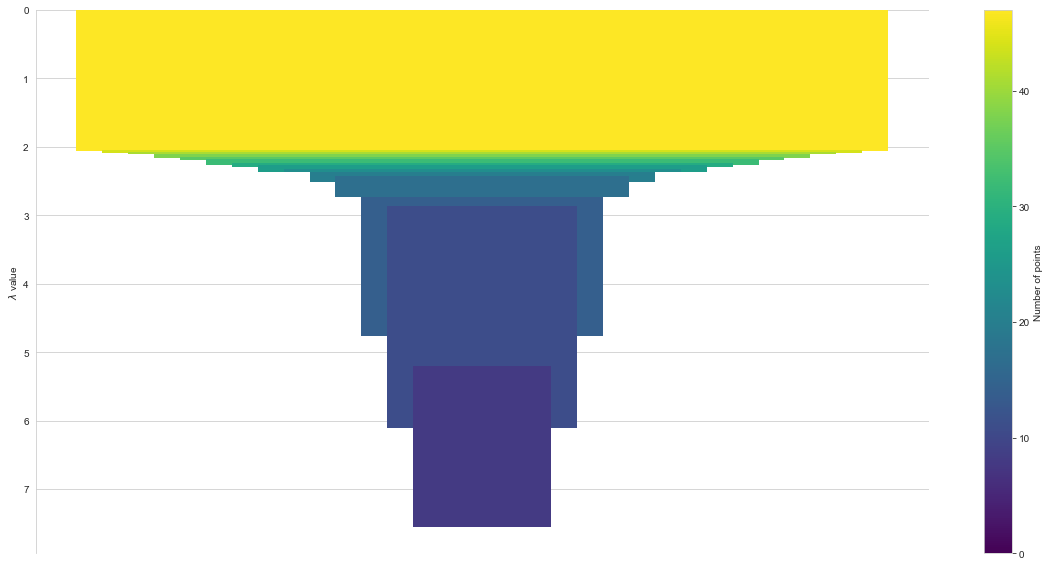

In [62]:
clusterer.condensed_tree_.plot()

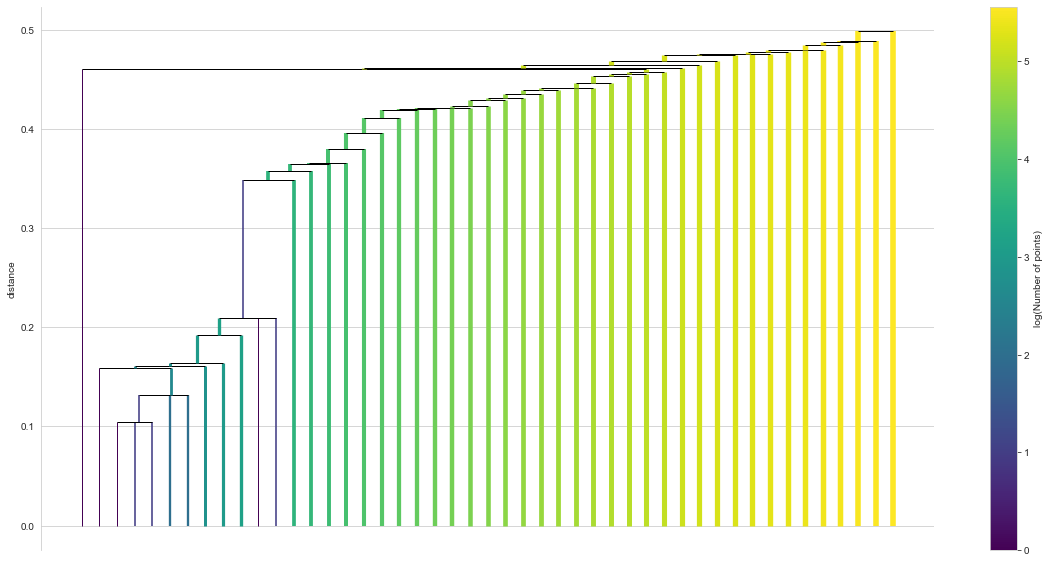

In [63]:
clusterer.single_linkage_tree_.plot()

In [64]:
clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1], dtype=int64)

In [65]:
unique, counts = np.unique(clusterer.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 47}

In [66]:
unique

array([-1], dtype=int64)

In [67]:
for i in unique:
    indices = np.where(clusterer.labels_ == i)[0]

    print(f'cluster {i} (size {len(indices)}):')
    print(indices)
    for idx in indices:
        display(df_piv.index[idx])
    print('\n')

cluster -1 (size 47):
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]


'Debate and argument appeal to you.'

'Keeping things going is your strength, especially once someone else starts them.'

'Money and possessions are important to you for the feelings of security they bring.'

'Whatever you have set your sights on, you refuse to give up or let go of it.'

'You are adventurous.'

'You are consistent.'

'You are courageous.'

'You are gentle.'

'You are handy with your hands.'

'You are independent.'

'You are patient unless someone takes you too far.'

'You are quiet.'

'You are reliable.'

'You are romantic.'

'You are sensitive.'

'You are sentimental.'

'You are shy.'

'You are usually outspoken, sometimes to the point of bluntness.'

'You are usually slow to anger unless someone takes you too far.'

'You are very direct in thought, action, and speech and everyone knows how you feel.'

'You can handle more of the workload than most around you.'

'You enjoy building and seeing the results of your hard work.'

'You grasp concepts easily.'

'You have common sense to manage others.'

'You have the ability to manage others.'

'You may be a bit of a perfectionist.'

'You may be ambidextrous or mechanically inclined.'

"You may become impatient with those who do n't learn as quickly."

'You never find it difficult to change your mind or course in mid-stream.'

'You never give up.'

'You prefer a regular routine, defined responsibilities.'

'You prefer a regular routine, defined tasks.'

'You tend to be dependable.'

'You tend to be friendly.'

'You tend to be honest.'

'You tend to be idealistic.'

'You tend to be industrious, efficient, practical, exacting, scientific, organized, shy, thrifty, studious, economical, and punctual.'

'You tend to be open-minded.'

'You tend to be optimistic.'

'You tend to be versatile.'

'Your mind is analytical.'

'Your mind is deep.'

'Your work is usually neat.'

'Your work is usually orderly.'

'you dislike dirt.'

'you dislike messes.'

'you probably have a good head for numbers.'

In [68]:
silhouette_score(dist_mat, clusterer.labels_, metric='precomputed')

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

the optimal clustering from HDBSCAN doesn't seem to have face validity, upon inspection of the sentences in the generated clusters.